In [2]:
%load_ext autoreload
%autoreload 2
from model import scVI_final as scVI
from model.vae import format_time

import tensorflow as tf
from benchmarking import *
import numpy as np
import time

ImportError: No module named model

In [3]:
data_path = "/home/ubuntu/single-cell-scVI/data/10x1M/data_small.hdf5"
import h5py
f = h5py.File(data_path)
expression_train = f["data_train"][:10000]
expression_test = f["data_test"][:10000]
import matplotlib.pyplot as plt
log_library_size = np.log(np.sum(expression_train, axis=1))
mean, var = np.mean(log_library_size), np.var(log_library_size)

NameError: name 'np' is not defined

In [22]:
f["data_train"]

<HDF5 dataset "data_train": shape (1175514, 720), type "<i4">

In [23]:
def next_batch(data, batch_size):
    index = np.random.choice(np.arange(data.shape[0]), size=batch_size)
    return data[index]

In [24]:
def eval_likelihood(data, sess, kl=1):
    s = 0
    for i in range(10):
        dic_full = {expression: data[1000 * i: 1000 * (i+ 1)], training_phase:False, kl_scalar:kl}
        s += sess.run(model.loss, feed_dict=dic_full) 
    return s / 10.

In [25]:
def train_model(num_epochs, expression_train, expression_test, step, batch_size, kl=1):
    iterep = int(expression_train.shape[0]/float(batch_size))-1
    training_history = {"t_loss":[], "v_loss":[], "time":[], "epoch":[]}
    training_history["n_hidden"] = model.n_hidden
    training_history["model"] = model.__class__.__name__
    training_history["n_input"] = model.n_input
    training_history["dropout_nn"] = model.dropout_rate
    training_history["learning_rate"] = learning_rate
    training_history["dispersion"] = model.dispersion
    training_history["epsilon"] = epsilon
    training_history["n_layers"] = model.n_layers
    begin = time.time()
    
    
    for t in range(iterep * num_epochs):
    
        # arange data in batches
        #x_train, b_train = next_batch(expression_train, batch_train, batch_size)
        #x_test, b_test = next_batch(expression_test, batch_test, batch_size)

        #prepare data dictionaries
        #dic_train = {expression: x_train, batch:b_train.A, training_phase:True, kl_scalar:0}
        #dic_test = {expression: x_test, batch:b_test.A, training_phase:False, kl_scalar:0}
        
        # arange data in batches
        #x_train = next_batch(expression_train, batch_size).astype(np.float32)
        x_train = expression_train[batch_size * (t%iterep) :batch_size * (t%iterep + 1) ].astype(np.float32)
        x_test = next_batch(expression_test, batch_size).astype(np.float32)

        #prepare data dictionaries
        dic_train = {expression: x_train, training_phase:True, kl_scalar:kl}
        dic_test = {expression: x_test,  training_phase:False, kl_scalar:kl} 
        
        # run an optimization set
        _, l_tr = sess.run([step, model.loss], feed_dict=dic_train)
        end_epoch, epoch = t % iterep == 0, t / iterep

        if end_epoch:
            now = time.time()
            print epoch

            l_t = sess.run((model.loss), feed_dict=dic_test)

            training_history["t_loss"].append(l_tr)
            training_history["v_loss"].append(l_t)
            training_history["time"].append(format_time(int(now-begin)))
            training_history["epoch"].append(epoch)
            
            print 'Train / Test performance:', l_tr, l_t
            print "Elapsed Time:", training_history["time"][-1]
            
            #print eval_likelihood(expression_test, sess, kl=0)
            if np.isnan(l_tr):
                break
    return training_history

In [26]:
expression_train = f["data_train"][:50000]
batch_size = 128
learning_rate = 0.001
epsilon = 0.01
        
tf.reset_default_graph()
expression = tf.placeholder(tf.float32, (None, expression_train.shape[1]), name='x')
kl_scalar = tf.placeholder(tf.float32, (), name='kl_scalar')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=epsilon)
training_phase = tf.placeholder(tf.bool, (), name='training_phase')

model = scVI.scVIModel(expression=expression, kl_scale=kl_scalar, \
                         optimize_algo=optimizer, phase=training_phase, \
                          library_size_mean=mean, library_size_var=var, \
                          n_layers=1, n_hidden=128)

# Session creation
sess = tf.Session()
sess.run(tf.global_variables_initializer())

result = train_model(120, expression_train, expression_test, model.train_step, batch_size)

Running scVI on 720 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
Will apply zero inflation
1 hidden layers at 128 each for a final 10 latent space
0
Train / Test performance: 19766.5 17626.2
Elapsed Time: 0:00:00
1
Train / Test performance: 1592.69 1799.25
Elapsed Time: 0:00:06


KeyboardInterrupt: 

## Test NB vs ZINB

In [11]:
n_cells = 10000
expression_train = f["data_train"][:n_cells]
#expression_train = f["data_train"]
batch_size = 128
learning_rate = 0.005
epsilon = 0.01

res = {True:[], False:[]}

for i in range(10):
    if i <= 5:
        zi = False
    else:
        zi = True
        
    tf.reset_default_graph()
    expression = tf.placeholder(tf.float32, (None, expression_train.shape[1]), name='x')
    kl_scalar = tf.placeholder(tf.float32, (), name='kl_scalar')
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=epsilon)
    training_phase = tf.placeholder(tf.bool, (), name='training_phase')

    model = scVI.scVIModel(expression=expression, kl_scale=kl_scalar, \
                             optimize_algo=optimizer, phase=training_phase, \
                              library_size_mean=mean, library_size_var=var, \
                              n_layers=1, n_hidden=128, zi=zi)

    # Session creation
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    train_model(120, expression_train, expression_test, model.train_step, batch_size, kl=1)
    res[zi].append(eval_likelihood(expression_test, sess, kl=1))

Running scVI on 888 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
1 hidden layers at 128 each for a final 10 latent space
0
Train / Test performance: 16704.7 nan
Elapsed Time: 0:00:00
1
Train / Test performance: 1984.23 2429.54
Elapsed Time: 0:00:00
2
Train / Test performance: 1812.01 1932.51
Elapsed Time: 0:00:01
3
Train / Test performance: 1667.71 1686.91
Elapsed Time: 0:00:02


KeyboardInterrupt: 

In [8]:
eval_likelihood(expression_test, sess, kl=0)

1156.8517578125

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def show_tSNE(tsne, name):

    plt.figure(figsize=(10, 10))
    plt.scatter(tsne[:, 0], tsne[:, 1])    

    plt.axis("off")
    plt.title("tSNE for latent space " + name, fontsize=16)

In [10]:
def eval_latent(data, sess, model, combine=False):
    dic_full = {expression: data, training_phase:False, kl_scalar:1}
    if model.__class__.__name__ == 'scVIModel':
        temp = sess.run(model.sampling_latent, feed_dict=dic_full)
        if combine:
            return np.hstack((temp[0], (temp[1] - mean) / np.sqrt(var)))
        else:
            return temp[0]
    else:
        return sess.run(model.sampling_latent, feed_dict=dic_full)

In [12]:
latent = eval_latent(expression_train[:10000], sess, model, combine=False)
tsne = TSNE().fit_transform(latent)

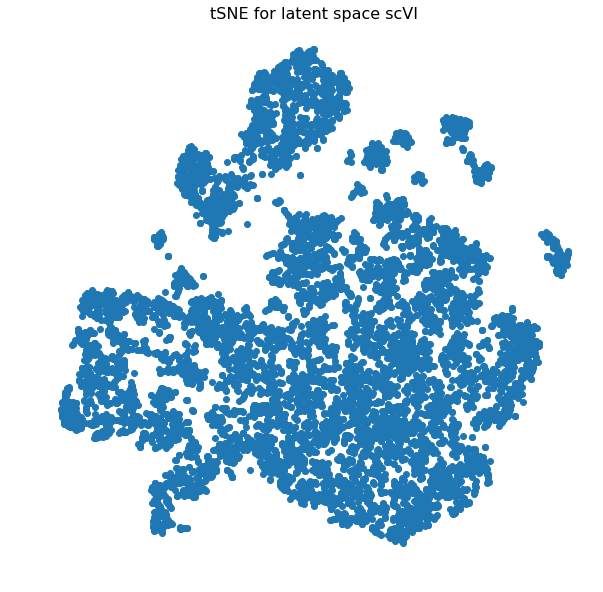

In [16]:
show_tSNE(tsne, "scVI")
plt.savefig("1M.pdf", dpi=300)

In [20]:
train_model(200, expression_train, expression_test, model.train_step, batch_size)

0
Train / Test performance: 1161.21 1155.58
Elapsed Time: 0:00:00
1159.25379639
1
Train / Test performance: 1159.82 1179.95
Elapsed Time: 0:01:57
1139.2855835
2
Train / Test performance: 1156.18 1135.46
Elapsed Time: 0:03:55
1137.26328125
3
Train / Test performance: 1159.4 1143.25
Elapsed Time: 0:05:51
1137.36618652
4
Train / Test performance: 1154.77 1155.09
Elapsed Time: 0:07:47
1140.41973877
5
Train / Test performance: 1154.4 1080.13
Elapsed Time: 0:09:43
1136.19875488
6
Train / Test performance: 1153.85 1138.41
Elapsed Time: 0:11:40
1140.52241211
7
Train / Test performance: 1153.03 1142.94
Elapsed Time: 0:13:36
1137.90355225
8
Train / Test performance: 1155.43 1108.23
Elapsed Time: 0:15:33
1137.46722412
9
Train / Test performance: 1153.05 1139.31
Elapsed Time: 0:17:28
1136.84595947
10
Train / Test performance: 1153.25 1138.88
Elapsed Time: 0:19:24
1135.55107422
11
Train / Test performance: 1150.0 1121.4
Elapsed Time: 0:21:21
1134.97113037
12
Train / Test performance: 1147.28 1152.5

KeyboardInterrupt: 

In [33]:
train_model(1, expression_test, expression_test, model.test_step, batch_size)

0
Train / Test performance: 1147.67 1111.02
Elapsed Time: 0:00:00


{'dispersion': False,
 'dropout_nn': 0.1,
 'epoch': [0],
 'epsilon': 0.01,
 'learning_rate': 0.005,
 'model': 'scVIModel',
 'n_hidden': 256,
 'n_input': 720,
 'n_layers': 3,
 't_loss': [1147.6743],
 'time': ['0:00:00'],
 'v_loss': [1111.0244]}

## imputation

In [1]:
data_path = "/home/ubuntu/single-cell-scVI/data/10x1M/"
X_zero, i, j, ix = \
        np.load(data_path + "imputation/X_zero.npy"), np.load(data_path + "imputation/i.npy"),\
        np.load(data_path + "imputation/j.npy"), np.load(data_path + "imputation/ix.npy")

NameError: name 'np' is not defined

In [15]:
n_cells = 10000
expression_train = f["data_train"][:n_cells].astype(np.float32)
batch_size = 128
learning_rate = 0.001
epsilon = 0.01

tf.reset_default_graph()
expression = tf.placeholder(tf.float32, (None, expression_train.shape[1]), name='x')
kl_scalar = tf.placeholder(tf.float32, (), name='kl_scalar')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=epsilon)
training_phase = tf.placeholder(tf.bool, (), name='training_phase')

model = scVI.scVIModel(expression=expression, kl_scale=kl_scalar, \
                         optimize_algo=optimizer, phase=training_phase, \
                          library_size_mean=mean, library_size_var=var, \
                          n_layers=1, n_hidden=128, log_variational=True)

# Session creation
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Running scVI on 888 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
Will apply zero inflation
1 hidden layers at 128 each for a final 10 latent space


In [22]:
train_model(300, expression_train, expression_test, model.train_step, batch_size)

0
Train / Test performance: 1121.09 1176.1
Elapsed Time: 0:00:00
1130.5631958
1
Train / Test performance: 1123.56 1126.08
Elapsed Time: 0:00:01
1130.90078125
2
Train / Test performance: 1122.27 1098.45
Elapsed Time: 0:00:02
1134.05029297
3
Train / Test performance: 1122.74 1108.44
Elapsed Time: 0:00:03
1133.48330078
4
Train / Test performance: 1124.18 1108.75
Elapsed Time: 0:00:04
1130.61502686
5
Train / Test performance: 1122.95 1158.9
Elapsed Time: 0:00:06
1132.53894043
6
Train / Test performance: 1124.22 1141.73
Elapsed Time: 0:00:07
1130.71564941
7
Train / Test performance: 1124.85 1121.66
Elapsed Time: 0:00:08
1130.05899658
8
Train / Test performance: 1128.19 1121.76
Elapsed Time: 0:00:09
1132.52525635
9
Train / Test performance: 1125.8 1138.53
Elapsed Time: 0:00:10
1132.24664307
10
Train / Test performance: 1123.1 1142.63
Elapsed Time: 0:00:12
1130.67532959
11
Train / Test performance: 1126.25 1116.38
Elapsed Time: 0:00:13
1129.48814697
12
Train / Test performance: 1124.06 1153.4

KeyboardInterrupt: 

In [21]:
def eval_imputed_data(model):
    dic_zero = {expression: X_zero, training_phase:False, kl_scalar:1.} 
    zero_, dropout_, rate_  = sess.run((model.zero_prob, model.dropout_prob, model.px_rate), \
                                       feed_dict=dic_zero)
    print(imputation_error(rate_, expression_train, i, j, ix))
    print(imputation_dropout(zero_, X_zero, i, j, ix))
    print(imputation_dropout(dropout_, X_zero, i, j, ix))

In [22]:
eval_imputed_data(model)

1.04269
(0.13127136, 0.35251546)
(0.0041087237, 0.56929839)
